# Binary Sentiment Analysis of French Movie Reviews

### Objectives
1. Text cleaning
2. Text preprocessing for custom embedding Neural Network
3. Train RNN model for sentiment analysis

⚠️ This notebook will be your final deliverable. 
- Make sure it can run "restart and run all"
- Delete useless code cells
- Do not "clear output"

# 0. Load data

Our dataset contains 30,000 french reviews of movies, along with the binary class 1 (positive) or 0 (negative) score

In [2]:
import pandas as pd
import numpy as np

In [3]:
# We load the dataset for you
data = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/certification_paris_2021Q1/movies.csv')
data

,review,polarity
0,Ça commence à devenir énervant d'avoir l'impre...,0
1,"J'ai aimé ce film, si il ressemble a un docume...",1
2,Une grosse merde ce haneke ce faire produire p...,0
3,"Beau mélodrame magnifiquement photographié, ""V...",1
4,A la poursuite du diamant vers est un film pro...,1
...,...,...
29946,Le meilleur film de super-héros derrière le ba...,1
29947,Un drame qui est d'une efficacité remarquable....,1
29948,"Une daube hollywoodienne de plus, aucun intérê...",0
29949,Et voilà un nouveau biopic sur la star du X Li...,0


In [16]:
# We create features
y = data.polarity
X = data.review

# We analyse class balance
print(pd.value_counts(y))

1    15051
0    14900
Name: polarity, dtype: int64


In [5]:
# We check various reviews
print(f'polarity: {y[0]} \n')
print(X[0])

polarity: 0 

Ça commence à devenir énervant d'avoir l'impression de voir et revoir le même genre de film à savoir : la comédie romantique, surement le genre le plus prolifique de le production française actuelle. Le problème c'est que l'on a souvent affaire à des niaiseries de faible niveau comme celui ci. Avec un scenario ultra balisé et conventionnel, c'est à se demander comment ça peut passer les portes d'un producteur. Bref cette sempiternel histoire d'un homme mentant au nom de l'amour pour reconquérir une femme et qui à la fin se prend son mensonge en pleine figure est d'une originalité affligeante, et ce n'est pas la présence au casting de l'ex miss météo Charlotte Le Bon qui rêve surement d'avoir la même carrière que Louise Bourgoin qui change la donne.


# 1. Clean Text

❓ We need to give a _quick & dirty_ cleaning to all the sentences in the dataset. Create a variable `X_clean` of similar shape, but with the following cleaning:
- Replace french accents by their non-accentuated equivalent using the [unidecode.unidecode()](https://pypi.org/project/Unidecode/) method
- Reduce all uppercases to lowercases
- Remove any characters outside of a-z, for instance using `string.isalpha()`

😌 You will be given the solution `X_clean` in the next question to make sure you can complete the challenge

In [7]:
! pip install unidecode

     |████████████████████████████████| 241 kB 1.8 MB/s eta 0:00:01


In [13]:
from unidecode import unidecode
def func_unidecode(df_series):
    new_series = []
    for text in df_series:
        new_series.append(unidecode(text))
    return new_series

In [17]:
X_unaccented = func_unidecode(X)

In [19]:
def lowercase(df_series):
    new_series = []
    for text in df_series:
        new_series.append(text.lower())
    return new_series

In [20]:
X_lower = lowercase(X_unaccented)

In [23]:
X_lower[0].isalpha()

False

In [26]:
import string
def remove_punct(df_series):
    new_series = []
    for text in df_series:
        for punctuation in string.punctuation:
            text = text.replace(punctuation, '')
        new_series.append(text)
    return new_series

In [30]:
X_clean = remove_punct(X_lower)
X_clean = pd.Series(X_clean)

In [32]:
X_clean.shape

(29951,)

In [31]:
from nbresult import ChallengeResult

result = ChallengeResult('C14',
    shape = X_clean.shape,
    first_sentence = X_clean[0]
)
result.write()

# 2. Preprocess data

Now that we have clean sentences, we need to convert each one into a list of integers of fixed size
- For example, the sentence: `"this was good"` should become something like `array([1, 3, 18, 0, 0, 0, ...0], dtype=int32)` where each integer match to a each _unique_ word in your corpus of sentences.

❓ Create a numpy ndarray `X_input` of shape (29951, 100) that will be the direct input to your Neutral Network. 

- 29951 represents the number of reviews in the dataset `X_clean`
- 100 represents the maximum number of words to keep for each movie review.
- It must contain only numerical values, without any `NaN`
- In the process, compute and save the number of _unique_ words in your cleaned corpus under `vocab_size` variable

👉 First, you **must** start back from the clean solution below (14Mo)

In [33]:
X_clean = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification_paris_2021Q1/movies_X_clean.csv")['review']
X_clean

0        ca commence a devenir enervant de voir et revo...
1        aime ce film si il ressemble a un documentaire...
2        une grosse merde ce haneke ce faire produire p...
3        beau melodrame magnifiquement photographie ver...
4        a la poursuite du diamant vers est un film pro...
                               ...                        
29946    le meilleur film de derriere le batman de nola...
29947    un drame qui est efficacite remarquable un fil...
29948    une daube hollywoodienne de plus aucun interet...
29949    et voila un nouveau biopic sur la star du x li...
29950    un film qui fait vieux avec des acteurs pas to...
Name: review, Length: 29951, dtype: object

In [42]:
from nltk.tokenize import word_tokenize
X_tokenized = []
for text in X_clean:
    X_tokenized.append(word_tokenize(text))

In [67]:
def to_dict(X):
    word_to_id = {}
    i = 1
    for sentence in X:
        for word in sentence:
            if word not in word_to_id:
                word_to_id[word] = i
                i += 1
    return word_to_id

In [69]:
word_to_id = to_dict(X_tokenized)

In [87]:
vocab_size = len(word_to_id)
vocab_size

62379

In [80]:
def vectorize(X, word_to_id):
    X_vectorized = []
    for sentence in X:
        new_sentence = []
        for word in sentence:
            try:
                new_sentence.append(word_to_id[word])
            except:
                pass
        X_vectorized.append(np.asarray(new_sentence[:100]))
    return np.asarray(X_vectorized)

In [81]:
X_vectorized = vectorize(X_tokenized, word_to_id)

In [82]:
X_vectorized.shape

(29951,)

In [83]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [84]:
X_pad = pad_sequences(X_vectorized, padding='post', dtype='float32', value=0)

In [86]:
X_pad.shape

(29951, 100)

In [88]:
X_input = X_pad

In [93]:
from nbresult import ChallengeResult

result = ChallengeResult('C1415',
    type_X = type(X_input),
    shape = X_input.shape, 
    input_1 = X_input[1], 
)
result.write()

# 3. Neural Network

❓Create and fit a Neural Netork that takes `X_input` and `y` as input, to binary classify each sentence's sentiment

- You cannot use transfer learning or other pre-existing Word2Vec models
- You must use a "recurrent" architecture to _capture_ a notion of order in the sentences' words
- The performance metrics for this task is "accuracy"
- Store your model in a variable `model` 
- Store the result your `model.fit()` in a variable `history`. 
- ⚠️ `history.history` must comprises a measure of the `val_accuracy` at each epoch.
- You don't need to cross-validate your model

😌 Don't worry, you will not be judged on your computer power: You should be able to reach accuracy significantly better than baseline in less than 3 minutes even without GPUs.

👉 But first, you **must** start back from the solution below (70Mo)

In [94]:
url = 'https://wagon-public-datasets.s3.amazonaws.com/certification_paris_2021Q1/movies_X_input.csv'
X_input = np.genfromtxt(url, delimiter=',', dtype='int32')

In [98]:
X_input.shape

(29951, 100)

In [106]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Embedding

def init_model(vocab_size):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=50))
    model.add(layers.GRU(20, return_sequences=False, activation='tanh'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

def compile_model(model):
    model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics='accuracy')
    return model

In [107]:
from tensorflow.keras import callbacks
es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

model = init_model(vocab_size+1)
model = compile_model(model)

history = model.fit(X_input, y,
              batch_size=16,
              verbose=1,
              validation_split = 0.2,
              callbacks=[es],
              epochs=30)

Epoch 1/30
1498/1498 [==============================] - 146s 95ms/step - loss: 0.6275 - accuracy: 0.6037 - val_loss: 0.3084 - val_accuracy: 0.8863
Epoch 2/30
1498/1498 [==============================] - 129s 86ms/step - loss: 0.2708 - accuracy: 0.8987 - val_loss: 0.2110 - val_accuracy: 0.9150
Epoch 3/30
1498/1498 [==============================] - 130s 87ms/step - loss: 0.1763 - accuracy: 0.9332 - val_loss: 0.2070 - val_accuracy: 0.9150
Epoch 4/30
1498/1498 [==============================] - 138s 92ms/step - loss: 0.1439 - accuracy: 0.9467 - val_loss: 0.2258 - val_accuracy: 0.9120
Epoch 5/30
1498/1498 [==============================] - 125s 84ms/step - loss: 0.1308 - accuracy: 0.9524 - val_loss: 0.2278 - val_accuracy: 0.9120
Epoch 6/30
1498/1498 [==============================] - 128s 86ms/step - loss: 0.1164 - accuracy: 0.9548 - val_loss: 0.2207 - val_accuracy: 0.9140
Epoch 7/30
1498/1498 [==============================] - 130s 86ms/step - loss: 0.1044 - accuracy: 0.9640 - val_loss: 0

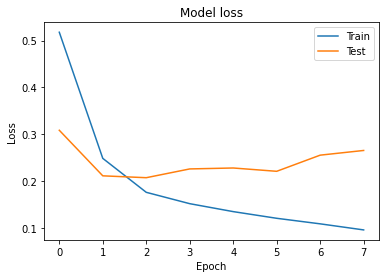

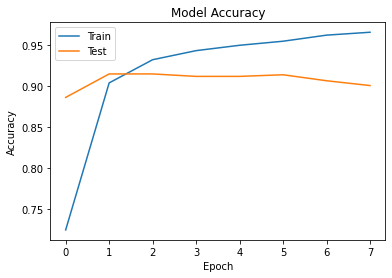

In [109]:
import matplotlib.pyplot as plt
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
plot_loss_accuracy(history)

The model overfits realy fast. 2 epoch are enough

In [110]:
from nbresult import ChallengeResult
result = ChallengeResult('C1517',
                         history=history.history)
result.write()